In [7]:
#import torch
#import torchaudio
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import librosa 
import os
import numpy
import scipy
#device = torch.device('cuda:0')
#print(torch.__version__)

In [8]:
#音声データのルートディレクトリ
ROOT_PATH = '/home/iot/notebooks/voicechainger/dataset/'


In [9]:
#音声データ名
speakers=['fujitou_normal',"uemura_normal"]

In [10]:
word_training=[]    # 学習用のFCCの値を格納する配列
speaker_training=[] # 学習用のラベルを格納する配列

In [11]:
def getMfcc(filename):
    y, sr = librosa.load(filename)      # 引数で受けとったファイル名でデータを読み込む。
    return librosa.feature.mfcc(y=y, sr=sr) # MFCCの値を返します。

AttributeError: module 'scipy' has no attribute 'io'

In [13]:
# 各ディレクトリごとにデータをロードし、MFCCを求めていく
for speaker in speakers:
    # どの話者のデータを読み込んでいるかを表示
    print('Reading data of %s...' % speaker)
    # 話者名でディレクトリを作成しているため<ルートパス+話者名>で読み込める。
    path = os.path.join(ROOT_PATH + speaker)    
    # パス、ディレクトリ名、ファイル名に分けることができる便利なメソッド
    print("path",path)
    for pathname, dirnames, filenames in os.walk(path): 
        
        for filename in filenames:
            if filename.endswith('.wav'):
                mfcc=getMfcc(os.path.join(pathname, filename))
                word_training.append(mfcc.T)    # word_trainingにmfccの値を追加
                label=numpy.full((mfcc.shape[1] ,), 
                speakers.index(speaker), dtype=numpy.int)   # labelをspeakersのindexで全て初期化
                speaker_training.append(label)  # speaker_trainingにラベルを追加

word_training=numpy.concatenate(word_training)  # ndarrayを結合
speaker_training=numpy.concatenate(speaker_training)

Reading data of fujitou_normal...
path /home/iot/notebooks/voicechainger/dataset/fujitou_normal
Reading data of uemura_normal...
path /home/iot/notebooks/voicechainger/dataset/uemura_normal


In [14]:
print(word_training)
print(speaker_training)

[[-6.6066406e+02  1.1410446e+00  1.1401461e+00 ...  1.0570574e+00
   1.0471573e+00  1.0367631e+00]
 [-6.6093982e+02  7.5113100e-01  7.5036061e-01 ...  6.7935735e-01
   6.7091817e-01  6.6206384e-01]
 [-6.6067340e+02  1.1273654e+00  1.1250329e+00 ...  9.1680086e-01
   8.9298606e-01  8.6821234e-01]
 ...
 [-7.0438275e+02  2.8157856e+00  2.8066204e+00 ...  2.0350227e+00
   1.9528587e+00  1.8687596e+00]
 [-7.0470093e+02  2.3664937e+00  2.3595586e+00 ...  1.8057035e+00
   1.7498310e+00  1.6931714e+00]
 [-7.0441199e+02  2.7679110e+00  2.7392612e+00 ...  1.0168092e+00
   9.0377676e-01  7.9977059e-01]]
[0 0 0 ... 1 1 1]


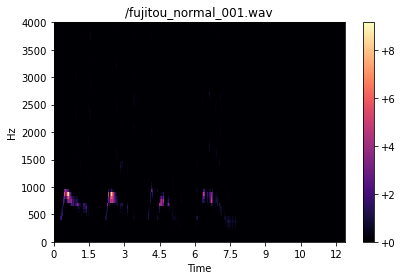

In [12]:
import librosa.display
import matplotlib.pyplot as plt

librosa.display.specshow(mel,
                         x_axis='time',
                         y_axis='linear',
                         sr=sr,
                         hop_length=160)

plt.colorbar(format='%+2.0f')
plt.title('/fujitou_normal_001.wav')
plt.ylim(0, 4000)
plt.tight_layout()
plt.show()

In [15]:
# カーネル係数を1e-4で学習
clf = SVC(C=1, gamma=1e-4)      # SVCはクラス分類をするためのメソッド
clf.fit(word_training, speaker_training)    # MFCCの値とラベルを組み合わせて学習
print('Learning Done')

Learning Done


In [16]:
counts = []     # predictionの中で各値（予測される話者のインデックス）が何回出ているかのカウント
file_list = []  # file名を格納する配列

# 各話者のテストデータが入っている~testというディレクトリごとにMFCCを求めていく
for speaker in speakers:
    path = os.path.join(ROOT_PATH + '%s_test' % speaker)
    for pathname, dirnames, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('.wav'):
                mfcc = getMfcc(os.path.join(pathname, filename))
                prediction = clf.predict(mfcc.T)    # MFCCの値から予測した結果を代入
                # predictionの中で各値（予測される話者のインデックス）が何回出ているかをカウントして追加
                counts.append(numpy.bincount(prediction))   
                file_list.append(filename)  # 実際のファイル名を追加

In [17]:
total = 0   # データの総数
correct = 0 # 正解の数

# 推測される話者の名前がファイル名の頭と一致したらCorrect
for filename, count in zip(file_list, counts):
    total += 1
    result = speakers[numpy.argmax(count-count.mean(axis=0))]   # 
    if  filename.startswith(result):
        correct += 1

print('score : ' + str(correct / total))

score : 0.02


In [18]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
plt.figure()
plt.plot(waveform.t().numpy())

NameError: name 'waveform' is not defined

In [19]:
specgram = torchaudio.transforms.Spectrogram()(waveform)
print("Shape of spectrogram: {}".format(specgram.size()))
plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

NameError: name 'torchaudio' is not defined

In [51]:
print(specgram)

tensor([[[3.0820e-05, 1.8261e-05, 6.6538e-07,  ..., 4.0046e-07,
          1.6783e-06, 2.1682e-05],
         [7.0454e-06, 5.8383e-06, 2.5485e-06,  ..., 1.4624e-05,
          9.4132e-07, 7.5208e-06],
         [7.8559e-08, 2.3399e-09, 2.9551e-07,  ..., 5.1487e-06,
          1.8955e-06, 5.6587e-07],
         ...,
         [5.1868e-06, 2.0740e-06, 2.3419e-06,  ..., 8.4794e-07,
          4.9973e-07, 1.1911e-06],
         [8.4004e-07, 7.4800e-06, 1.0439e-06,  ..., 5.2665e-07,
          2.3289e-06, 2.3278e-06],
         [7.6776e-06, 2.6871e-06, 9.0047e-06,  ..., 4.2106e-07,
          6.4499e-06, 1.8260e-07]]])


In [54]:
print(specgram.log2()[0,:,:])

tensor([[-14.9858, -15.7409, -20.5193,  ..., -21.2518, -19.1846, -15.4931],
        [-17.1149, -17.3860, -18.5819,  ..., -16.0613, -20.0188, -17.0207],
        [-23.6016, -28.6709, -21.6903,  ..., -17.5674, -19.0090, -20.7530],
        ...,
        [-17.5567, -18.8791, -18.7039,  ..., -20.1695, -20.9323, -19.6792],
        [-20.1830, -17.0285, -19.8696,  ..., -20.8567, -18.7119, -18.7126],
        [-16.9909, -18.5055, -16.7609,  ..., -21.1795, -17.2423, -22.3848]])


In [15]:
#cuda(gpu)の使い方
c = torch.ones([4], dtype=torch.float64, device=device)
d = torch.zeros([4, 1])
d = d.to(device)
print(c)
print(d)

tensor([1., 1., 1., 1.], device='cuda:0', dtype=torch.float64)
tensor([[0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [42]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


In [43]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0437, -0.0025,  0.0203, -0.0644, -0.0327, -0.0828,  0.0859, -0.0147,
         -0.0671, -0.1345]], grad_fn=<AddmmBackward>)


In [44]:
net.zero_grad()
out.backward(torch.randn(1, 10))

In [45]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.5695, grad_fn=<MseLossBackward>)


In [47]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [48]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0122,  0.0002,  0.0117,  0.0004,  0.0076,  0.0015])


## LOW MEL

(128, 1238)


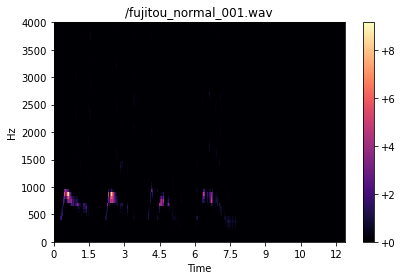

In [4]:
import librosa
import numpy as np

# Audio Data
audio_path = '/home/iot/notebooks/voicechainger/dataset/fujitou_normal/fujitou_normal_002.wav'

# Load
data, sr = librosa.load(
    audio_path,
    sr=16000)

# メル周波数のスペクトログラムを求める
mel = librosa.feature.melspectrogram(y=data,
                                     sr=sr,
                                     n_mels=128,
                                     n_fft=512,
                                     win_length=480,
                                     hop_length=160)

print(mel.shape)  # --> (128, 101)

# plot
import librosa.display
import matplotlib.pyplot as plt

librosa.display.specshow(mel,
                         x_axis='time',
                         y_axis='linear',
                         sr=sr,
                         hop_length=160)

plt.colorbar(format='%+2.0f')
plt.title('/fujitou_normal_001.wav')
plt.ylim(0, 4000)
plt.tight_layout()
plt.show()

In [34]:
mel

array([[4.05402631e-07, 2.12712507e-07, 1.15799153e-07, ...,
        1.21678070e-07, 2.58193751e-07, 1.83992384e-07],
       [2.58693916e-07, 1.40086186e-07, 1.05347006e-07, ...,
        9.78880905e-08, 2.41108751e-07, 1.09241292e-07],
       [1.09306228e-07, 6.63033290e-08, 9.59305879e-08, ...,
        7.44531334e-08, 2.26689224e-07, 3.28067067e-08],
       ...,
       [1.81675300e-10, 3.16532189e-10, 2.82116802e-10, ...,
        2.71390160e-10, 2.40431536e-10, 1.96501260e-10],
       [5.25423108e-11, 2.35258046e-11, 2.49341919e-11, ...,
        6.25522273e-11, 8.35229108e-11, 2.36117445e-11],
       [9.73160138e-13, 8.30422862e-13, 1.47408995e-12, ...,
        4.75264619e-12, 1.36718284e-12, 1.02586678e-12]], dtype=float32)

## Slaney formula

In [28]:
mel_slaney = librosa.hz_to_mel(8000) / 2
mel_slaney

22.622820235962482

In [29]:
librosa.mel_to_hz(mel_slaney)

1688.90846266178

## HTK formula

In [30]:
mel_htk = librosa.hz_to_mel(8000, htk=True) / 2
mel_htk

1420.0115233541594

In [31]:
librosa.mel_to_hz(mel_htk, htk=True)

1767.7925358506134

In [32]:
log_mel = np.log(mel)

## mel sklearn

In [ ]:


import matplotlib.pyplot as plt
from sklearn.svm import SVC
import librosa 
import os
import numpy
import scipy

In [40]:
ROOT_PATH = '/home/iot/notebooks/voicechainger/dataset/'
#音声データ名
speakers=['fujitou_normal',"uemura_normal"]

In [41]:
word_training=[]    # 学習用のFCCの値を格納する配列
speaker_training=[] # 学習用のラベルを格納する配列

In [42]:
def getMfcc(filename):
    y, sr = librosa.load(filename,sr=16000)      # 引数で受けとったファイル名でデータを読み込む。
    return librosa.feature.melspectrogram(y=data,sr=sr,n_mels=128,n_fft=512,win_length=480,hop_length=160)

In [43]:
for speaker in speakers:
    # どの話者のデータを読み込んでいるかを表示
    print('Reading data of %s...' % speaker)
    # 話者名でディレクトリを作成しているため<ルートパス+話者名>で読み込める。
    path = os.path.join(ROOT_PATH + speaker)    
    # パス、ディレクトリ名、ファイル名に分けることができる便利なメソッド
    print("path",path)
    for pathname, dirnames, filenames in os.walk(path): 
        for filename in filenames:
            if filename.endswith('.wav'):
                mel=getMfcc(os.path.join(pathname, filename))
                word_training.append(mel.T)    # word_trainingにmfccの値を追加
                label=numpy.full((mel.shape[1] ,), 
                speakers.index(speaker), dtype=numpy.int)   # labelをspeakersのindexで全て初期化
                speaker_training.append(label)  # speaker_trainingにラベルを追加

word_training=numpy.concatenate(word_training)  # ndarrayを結合
speaker_training=numpy.concatenate(speaker_training)

Reading data of fujitou_normal...
path /home/iot/notebooks/voicechainger/dataset/fujitou_normal
Reading data of uemura_normal...
path /home/iot/notebooks/voicechainger/dataset/uemura_normal


In [ ]:
# カーネル係数を1e-4で学習
clf = SVC(C=1, gamma=1e-4)      # SVCはクラス分類をするためのメソッド
clf.fit(word_training, speaker_training)    # MFCCの値とラベルを組み合わせて学習
print('Learning Done')